Let us model a road network as a directed trimodal graph $(\mathcal{G}, \mathcal{I}, \mathcal{V},  \mathcal{Q})$.

Let our traffic network have a set of nodes $\mathcal{N} = \mathcal{G} \cup \mathcal{I} \cup \mathcal{V}$ with labels $k, i, v \in \{-1,...,-K\}, \{1,...I,\}, \{0\}$, respectively.
As a consistant convention moving foreward, all nodes are organized into three sets:
* $g_k$ we denote as generator nodes, which node subset set we denote as $\mathcal{G}$ and are distinguised on edges by a negative index $k < 0$.
These nodes have out-degree one and in-degree zero, and they produce cars at some rate $\lambda_k \in \lambda$, adding them to the queue of their single out-edge.
* $n_i$ we denote as intersections, which node subset we denote as $\mathcal{I}$.
Each intersection has a state $x_i \in \mathcal{X}_i$ at every time $t$, and a policy $\pi_i \in \pi: \mathcal{X}_i \times \mathcal{Q}_i \to \mathcal{X}_i$, which determines the scheduled decision (for each time $t$ and neighboring queue states $\mathcal{Q}_i ⊆ \mathcal{Q},$ as described next) of that node to move cars from the queue of some in-edge of node $i$ to the queue of some out-edge of node $i$. The intersections move cars by changing their state $x_i$ to open traffic from some number of their in-queues, subject to constraints on which inlets can be open simultaneously.
* $\mathcal{V} = \{v_0\}$, the safe region.
This safe region does not need to be topoligically consistent with the road layout;
all safe exits can W.L.O.G. feed into the same safe node $V$. This node has zero out-degree.

Let there be a set of directed edges $\mathcal{Q}$ with labels $(m,n) \in \{\mathcal{N}\} \times \{\mathcal{N}\}$, representing an edge from node $n$ to node $m$.
Let this set be partitioned into subsets $\mathcal{Q}_i ⊆ \mathcal{Q}$ such that the edges $q_{ij} \in \mathcal{Q}$ have out-edges into node $n_i \in \mathcal{N}$ (or $v_0 \in \mathcal{V}$).
Note that, according to the degree constraints of the nodes, the following are true:
* $∄ j \in \mathbb{Z} : q_{j0} \in \mathcal{Q}$ (the safe node has out-degree zero)
* $∄ j \in \mathbb{Z},k<0 : q_{kj} \in \mathcal{Q}$ (the generator nodes have in-degree zero)
* $\forall k < 0,\ |\{j : j\ge 0, q_{jk} \in \mathcal{Q}\}| = 1$ (the generator nodes have out-degree one)

Every edge $q_{mn} \in \mathcal{Q}$ is a queue. Each queue has a current traffic volume $S_{mn}$ and a maximum capacity $C_{mn}$, as well as a minimum holding time for each car $T_{mn}(S_{mn})$, which is a function of the current volume of traffic in that queue.

We will make a simplifying assumption to the family of networks under consideration in the current work.
Let our network be an acyclic tree, meaning that every node has a unique path to the root node, which we make the safe node $v_0$. In this tree, all leaves are generators, and all intermediate nodes are intersections.


Let us now define the welfare cost.
Each car has an attribute $\tau_\text{car}(t)$ keeping track of how long it has been on the road since being generated, or the time it took to reach a safe node if it has already reached one.
We make the additional simplifying assumption that all cars are equivalent, up to what generator node $k$ they originate from, so properly $\tau_k$ is the expected value of total travel times over all cars originating from generator $g_k \in \mathcal{G}$ (in the limit $t \to \infty$, as long as cars eventually reach the safe nodes, the expected value will tend to $\tau_k$, as the incomplete cars make up a vanishingly small set).
Thus the welfare cost is simply a sum over all expected travel times, weighted by some parameter $\alpha_k$ (either $=1$ or $=\lambda_k$, depending on our model):
$$
W(\lambda, \pi)
= \sum_{g_{k} \in \mathcal{G}} \alpha_k \tau_k
= \sum_{g_{k} \in \mathcal{G}} \alpha_k
  \lim_{t \to \infty}
    \mathbb{E}_{\text{cars } \in g_k} \big[ \tau_{\text{car}}(t) \big]
$$

Let us now define individual cost functions for the intersections $n_i \in \mathcal{I}$ in our traffic model.
Let every queue have an attribute $\tau_{mn}(t)$ which measures the maximum time over all cars in the queue $q_{mn}$ at time $t$ that the cars have been waiting in that particular queue (as opposed to the expected total travel time recorded in $\tau_k$).
Then the intersection cost function is an objective which minimizes the maximum wait time over all incoming roads at that intersection:
$$
J_i(\lambda, \pi_i, \pi_{-i})
= \mathbb{E}_t \Big[ \max_{q_{ij} \in \mathcal{Q_i}}
  \tau_{ij}(t) \Big]
$$



# Define the Classes

In [49]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import abc
import random
from collections import deque
from collections import defaultdict
from collections import abc
import matplotlib.pyplot as plt

In [50]:
#@title method generate_random_DAG

def generate_random_DAG(num_nodes, seed=None):
    if seed is not None:
        np.random.seed(seed)
    G = nx.random_labeled_tree(num_nodes, seed=seed)
    DG = nx.DiGraph()
    DG.add_nodes_from(G.nodes())
    distances_to_node_0 = nx.shortest_path_length(G, target=0)
    for u, v in G.edges():
        if distances_to_node_0[u] < distances_to_node_0[v]:
            DG.add_edge(v, u)
        else:
            DG.add_edge(u, v)
    source_nodes = [n for n in DG.nodes() if DG.in_degree(n) == 0]
    nodes_to_remove = []
    for s in source_nodes:
        if s != 0 and DG.has_edge(s, 0):
            nodes_to_remove.append(s)
    relabel_map = {}
    for s in source_nodes:
        if s not in nodes_to_remove and s != 0:
            relabel_map[s] = -s
    Modified_DG = DG.copy()
    Modified_DG.remove_nodes_from(nodes_to_remove)
    DG = nx.relabel_nodes(Modified_DG, relabel_map, copy=True)
    return DG

In [51]:
#@title a method to build_road_network

def build_road_network(edges=None, num_nodes=None, pos=None, seed=None, verbose=0):
    if isinstance(edges, dict):
        edges = list(edges.items())
    if isinstance(edges, abc.Iterable):
        all_nodes = np.unique([node for edge in edges for node in edge])

        # Create a directed graph from the edges according to the source/sink conventions
        G = nx.DiGraph()
        G.add_nodes_from(all_nodes)
        all_nodes = list(G.nodes())

    if not num_nodes is None:
        G = generate_random_DAG(num_nodes, seed)
        all_nodes = list(G.nodes())
        edges = list(G.edges())

    # Define edges (queues) directed towards the root (0)
    # Connections from generators to intersections
    for edge in edges:
        G.add_edge(*edge)

    # Initialize lists for node categories
    generators = []
    safe_region = []
    intersections = []

    # Iterate through all nodes in the graph G
    for node in G.nodes():
        in_degree = G.in_degree(node)
        out_degree = G.out_degree(node)

        if in_degree == 0:
            generators.append(node)
        elif out_degree == 0:
            safe_region.append(node)
        else:
            intersections.append(node)

    # Add node attributes for type for easier visualization/categorization
    node_types = {}
    for node in generators:
        node_types[node] = 'generator'
    for node in intersections:
        node_types[node] = 'n intersection'
    for node in safe_region:
        node_types[node] = 'v safe Region'

    nx.set_node_attributes(G, node_types, 'type')

    if verbose > 0:
        # --- Visualization --- #
        plt.figure(figsize=(8, 6))

        if pos is None:
            pos = nx.spring_layout(G, seed=42)

        # Draw nodes with different colors based on type
        node_colors = []
        labels = {}
        for node in G.nodes():
            node_type = G.nodes[node]['type']
            labels[node] = f"${node_type[0]}_{{{node}}}$"
            if node_type == 'generator':
                node_colors.append('skyblue')
            elif node_type == 'n intersection':
                node_colors.append('salmon')
            else: # Safe Region
                node_colors.append('lightgreen')

        nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=700, alpha=0.9)
        nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrows=True, arrowsize=20, width=2, edge_color='gray')
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_weight='bold')

        plt.title("Traffic Network Tree Graph (Directed towards Root)")
        plt.axis('off')
        plt.show()

    return G

In [52]:
#@title Car class, id manager, method to increment time counter

class Car:
    def __init__(self, car_id, generator_id, current_queue=None):
        self.car_id = car_id
        self.generator_id = generator_id
        self.current_queue = current_queue  # The edge (u, v) where the car is located
        self.wait_time = 0                  # Time steps waiting in the current queue
        self.total_travel_time = 0          # Total time the car has spent in the system

    def __repr__(self):
        return f"Car(ID={self.car_id}, Queue={self.current_queue}, WaitTime={self.wait_time})"

class GlobalCarIDManager:
    _next_id = 0

    @staticmethod
    def get_next_id():
        GlobalCarIDManager._next_id += 1
        return GlobalCarIDManager._next_id

def increment_all_car_wait_times(all_queues_map):
    """Increments the wait_time and total_travel_time for all cars in all queues within all_queues_map."""
    for queue_id, traffic_queue in all_queues_map.items():
        for car in traffic_queue.get_cars_in_queue():
            car.wait_time += 1
            car.total_travel_time += 1

In [53]:
#@title Edge Queue model

class TrafficQueue:
    def __init__(self, queue_id, wait_time_func=lambda S : 2, capacity=5):
        self.queue_id = queue_id
        self._cars = deque()  # Use deque for efficient FIFO operations
        self.wait_time_func = wait_time_func
        self.capacity = capacity

    def add_car(self, car, override_capacity=False):
        if not override_capacity and len(self._cars) >= self.capacity:
          raise ValueError(f"Queue {self.queue_id} is full. Cannot add more cars.")
        # Ensure car's current_queue matches this queue's id
        car.current_queue = self.queue_id
        self._cars.append(car)

    def count_cars(self):
        return len(self._cars)

    def is_full(self):
        return len(self._cars) >= self.capacity

    def peek_top_car_wait_time(self):
        if not self.is_empty():
            return self._cars[0].wait_time
        return None # Indicate empty queue, or use None/raise error

    def is_empty(self):
        return len(self._cars) == 0

    def can_pop_next_car(self):
        if not self.is_empty():
            return self._cars[0].wait_time >= self.wait_time_func(self.count_cars())
        return False

    def pop_car(self):
        if self.can_pop_next_car():
            return self._cars.popleft()
        return None  # Or raise an error if preferred

    def get_cars_in_queue(self):
        return list(self._cars)

    def __repr__(self):
        return f"TrafficQueue($q_{{{self.queue_id[0]},{self.queue_id[1]}}},\n\t Cars={self.count_cars()},\n\t TopWaitTime={self.peek_top_car_wait_time() if not self.is_empty() else 'N/A'})"


In [54]:
#@title Generator node class

class Generator:
    def __init__(self, generator_node_id, traffic_queue, generation_rate=0.5):
        self.generator_node_id = generator_node_id
        self.traffic_queue = traffic_queue
        self.generation_rate = generation_rate # Probability of generating a car per time step

    def step(self):
        """Simulates one time step for the generator, potentially adding a car to its queue."""
        if random.random() < self.generation_rate:
            car_id = GlobalCarIDManager.get_next_id()
            new_car = Car(car_id, self.generator_node_id)
            self.traffic_queue.add_car(new_car, override_capacity=True)
            # print(f"Generator {self.generator_node_id}: Car {car_id} generated and added to queue {self.traffic_queue.queue_id}.")

    def __repr__(self):
        return f"Generator(g_{{{self.generator_node_id}}}, Rate={self.generation_rate})"


class GlobalGenerator:
    def __init__(self, incoming_queues_adj_list, generation_rates=0.5):
      self.incoming_queues_adj_list = incoming_queues_adj_list
      self.all_generators = []
      if not isinstance(generation_rates, abc.Mapping):
          default_gen_rate = generation_rates
          generation_rates = {}
          for destination_node, source_queues_map in incoming_queues_adj_list.items():
              generation_rates.update({src : default_gen_rate for src in source_queues_map.keys() if src < 0})
      for destination_node, source_queues_map in self.incoming_queues_adj_list.items():
          for source_node, traffic_queue_obj in source_queues_map.items():
              if source_node < 0:  # Check if the source node is a generator (negative index)
                  generator_instance = Generator(source_node, traffic_queue_obj, generation_rates[source_node])
                  self.all_generators.append(generator_instance)

    def run_all_generators(self):
        """Calls the step method on all instantiated Generator objects."""
        for generator in self.all_generators:
            generator.step()

    def __repr__(self):
      return "Instantiated Generator objects:" + str(self.all_generators)


In [55]:
#@title Intersection node class

class Intersection:
    def __init__(self, intersection_id, policy, all_queues_map, graph_G):
        self.intersection_id = intersection_id
        self.policy = policy
        self.all_queues_map = all_queues_map
        self.graph_G = graph_G
        self.cum_cost = 0

        # Identify all incoming edge tuples (e.g., (u, intersection_id))
        self.incoming_queues_ids = []
        for u in self.graph_G.predecessors(self.intersection_id):
            self.incoming_queues_ids.append((u, self.intersection_id))

        # Identify all outgoing edge tuples (e.g., (intersection_id, v))
        self.outgoing_queues_ids = []
        for v in self.graph_G.successors(self.intersection_id):
            self.outgoing_queues_ids.append((self.intersection_id, v))

        # Initialize current open incoming queues (list of queue IDs)
        self.current_state_incoming_queue_ids = []

        # Policy management
        self.policy_step_counter = 0

        # Assume only one outgoing queue for simplicity in this tree structure
        # The problem statement implies a tree structure where a node has at most one successor node, except for the safe node
        if self.outgoing_queues_ids:
            self.outgoing_queue_id = self.outgoing_queues_ids[0]
        else:
            self.outgoing_queue_id = None # For the root node (0) this might be empty

    def step(self, completed_cars_log):
        """Simulates car movement through the intersection for one time step."""
        self.policy(self)
        self.policy_step_counter += 1

        if self.outgoing_queue_id is None:
            # This intersection is a sink (like the safe node, though intersections usually have out-edges)
            # No cars can move out if there's no outgoing queue.
            # For this problem's context, intersections always have an outgoing queue to 0 or another intersection.
            # The safe region (node 0) is the only node with 0 out-degree.
            return

        outgoing_traffic_queue = self.all_queues_map[self.outgoing_queue_id]

        np.random.shuffle(self.current_state_incoming_queue_ids)
        max_queue_top_time = 0
        for incoming_queue_id in self.current_state_incoming_queue_ids:
            incoming_traffic_queue = self.all_queues_map[incoming_queue_id]
            if incoming_traffic_queue.peek_top_car_wait_time() is not None and max_queue_top_time < incoming_traffic_queue.peek_top_car_wait_time():
                max_queue_top_time = incoming_traffic_queue.peek_top_car_wait_time()

            # Move cars from the open incoming queue to the outgoing queue
            while incoming_traffic_queue.can_pop_next_car():
                if outgoing_traffic_queue.is_full():
                    break
                car = incoming_traffic_queue.pop_car()
                if car:
                    # Check if the car is moving to the safe node (node 0)
                    if self.outgoing_queue_id[1] == 0: # outgoing_queue_id is (current_node, destination_node)
                        completed_cars_log.append({'car_id': car.car_id, 'origin': car.generator_id, 'total_travel_time': car.total_travel_time})
                        # Car exits simulation, no need to add to outgoing queue
                    else:
                        car.wait_time = 0  # Reset wait time upon moving to a new queue
                        outgoing_traffic_queue.add_car(car)

        self.cum_cost += max_queue_top_time

    def get_cost(self):
        return self.cum_cost / self.policy_step_counter

    def __repr__(self):
        return (
            f"Intersection(ID={self.intersection_id}, "
            f"Incoming Queues={[qid for qid in self.incoming_queues_ids]}, "
            f"Outgoing Queue={self.outgoing_queue_id}, "
            f"Open Queues={self.current_state_incoming_queue_ids})"
        )


class GlobalIntersection:
    def __init__(self, intersections, policies, all_queues_map, graph_G):
        self.all_intersections = []
        self.all_queues_map = all_queues_map
        if not isinstance(policies, abc.Mapping):
            policies = {id : policies for id in intersections}
        for intersection_id in intersections:
            intersection_instance = Intersection(intersection_id, policies[intersection_id], all_queues_map, graph_G)
            self.all_intersections.append(intersection_instance)

    def run_all_intersections_step(self, completed_cars_log):
        """Calls the step method on all instantiated Intersection objects."""
        for intersection in self.all_intersections:
            intersection.step(completed_cars_log)

    def __len__(self):
        total_cars_in_queues = 0
        for queue in self.all_queues_map.values():
            total_cars_in_queues += queue.count_cars()
        return total_cars_in_queues

    def __repr__(self):
        return "Instantiated Intersection objects:\n" + "\n".join(str(i) for i in self.all_intersections)


In [56]:
#@title method to print a summary of the road network state
def print_network_state(incoming_queues_adj_list):
    print("Incoming Queues Adjacency List (Node -> [Sources]):")
    for node, sources in incoming_queues_adj_list.items():
      if node == 0:
        print(f"  $v_{node}$:")
      else:
        print(f"  $n_{node}$:")
      for source, queues in sources.items():
        if source < 0:
          print(f"    $g_{source}$: {queues}")
        else:
          print(f"    $n_{source}$: {queues}")

In [57]:
#@title method to run the road network for so many time steps and return stats

def run_simulation(G, num_timesteps, policies, generation_rates, wait_time_func=lambda S : 2 + 2*np.log(S), verbose=0):
  all_queues_map = {}
  for u, v in G.edges():
      all_queues_map[(u, v)] = TrafficQueue((u, v), wait_time_func=wait_time_func)

  incoming_queues_adj_list = {}
  for u, v in G.edges():
      if v not in incoming_queues_adj_list:
          incoming_queues_adj_list[v] = {}
      incoming_queues_adj_list[v][u] = all_queues_map[(u, v)]

  intersections = []
  for node in G.nodes():
      if G.nodes[node]['type'] == 'n intersection':
          intersections.append(node)

  global_generator = GlobalGenerator(incoming_queues_adj_list, generation_rates=generation_rates)
  global_intersection = GlobalIntersection(intersections, policies, all_queues_map, G)
  completed_cars_log = []
  queue_fullness_history = [] # Re-initialize to ensure it's empty before simulation
  intersection_costs_history = []

  if verbose > 0:
      print(f"Starting simulation for {num_timesteps} timesteps...")

  for t in range(num_timesteps):
      if verbose > 0:
          print(f"\n--- Time Step {t+1} ---")

      # 1. Generators generate cars
      global_generator.run_all_generators()

      # 2. Intersections move cars
      global_intersection.run_all_intersections_step(completed_cars_log)

      # 3. Increment wait times for all cars in all queues
      increment_all_car_wait_times(all_queues_map)

      # 4. Record current queue states for analysis
      current_queue_state = {}
      for qid, queue_obj in all_queues_map.items():
          current_queue_state[qid] = queue_obj.count_cars()
      queue_fullness_history.append(current_queue_state)

      intersection_costs = {}
      for intersection in global_intersection.all_intersections:
          intersection_costs[intersection.intersection_id] = intersection.get_cost()
      intersection_costs_history.append(intersection_costs)

      if verbose > 0:
          print("Current Queue Fullness:")
          for qid, count in current_queue_state.items():
              print(f"  Queue {qid}: {count} cars")

  percent_cars_finished =  (len(completed_cars_log) / (len(global_intersection) + len(completed_cars_log))) if global_intersection else 1 # case where no cars are on road

  if verbose > 0:
      print("\nSimulation finished.")
      print("\n--- Queue Fullness History ---")
      for i, state in enumerate(queue_fullness_history):
          print(f"Time Step {i+1}: {state}")

      print("\n--- Completed Cars Log ---")
      for _ in completed_cars_log:
        print(_)

  return completed_cars_log, queue_fullness_history, intersection_costs_history, percent_cars_finished

In [58]:

#@title method to compare different policies on the same network
def run_multiple_simulations(G, num_timesteps, all_policies_list, generation_rates, verbose=0):
    # generation rates must be conisitant across all simulations to compare policies
    results_by_policy = {}
    int_costs_by_policy = {}
    percent_cars_finished_by_policy = {}

    if verbose > 0: print(f"Running simulations for {num_timesteps} timesteps with different policies...")

    for policy in all_policies_list:
        policy_name = policy.__name__
        if verbose > 0: print(f"\n--- Running simulation with policy: {policy_name} ---")
        completed_cars_log, _, intersection_costs_history, percent_cars_finished = run_simulation(G, num_timesteps=num_timesteps, policies=policy, generation_rates=default_generation_rate, verbose=0)
        results_by_policy[policy_name] = completed_cars_log
        int_costs_by_policy[policy_name] = intersection_costs_history
        percent_cars_finished_by_policy[policy_name] = percent_cars_finished
        if verbose > 0: print(f"Simulation with {policy_name} completed. {len(completed_cars_log)} cars reached the destination.")

    if verbose > 0: print("All simulations completed.")
    if verbose > 0: print(f"Results stored for {len(results_by_policy)} policies: {list(results_by_policy.keys())}")

    grouped_travel_times = {}
    if verbose > 0: print("Grouping travel times by policy and generator...")
    for policy_name, completed_cars_log in results_by_policy.items():
        current_policy_data = defaultdict(list)
        for car_data in completed_cars_log:
            origin = car_data['origin']
            total_travel_time = car_data['total_travel_time']
            current_policy_data[origin].append(total_travel_time)
        grouped_travel_times[policy_name] = dict(current_policy_data)

    exp_int_costs_by_policy = {}
    for policy_name, intersection_costs_history in int_costs_by_policy.items():
        exp_int_costs = {}
        for int_costs_dict in intersection_costs_history:
            for int_id, cost in int_costs_dict.items():
                if int_id not in exp_int_costs:
                    exp_int_costs[int_id] = []
                exp_int_costs[int_id].append(cost)
        exp_int_costs_by_policy[policy_name] = exp_int_costs

    if verbose > 0:
        print("Travel times successfully grouped.")
        print(f"Grouped data available for policies: {list(grouped_travel_times.keys())}")
        print("Example structure for one policy (first generator): ")
        if grouped_travel_times:
            first_policy_name = list(grouped_travel_times.keys())[0]
            if grouped_travel_times[first_policy_name]:
                first_generator = list(grouped_travel_times[first_policy_name].keys())[0]
                print(f"  grouped_travel_times['{first_policy_name}']['{first_generator}'] = {grouped_travel_times[first_policy_name][first_generator][:5]}...")

    return grouped_travel_times, exp_int_costs_by_policy, percent_cars_finished_by_policy

In [59]:
#@title plot_individual_travel_times_by_policy

def plot_individual_travel_times_by_policy(grouped_travel_times):
    # 1. Determine unique generator IDs and policy names
    policy_names = list(grouped_travel_times.keys())
    # Collect all unique generator IDs across all policies
    all_generator_ids = set()
    for policy_data in grouped_travel_times.values():
        all_generator_ids.update(policy_data.keys())
    generator_ids = sorted(list(all_generator_ids)) # Sort for consistent plotting order

    num_generators = len(generator_ids)
    num_policies = len(policy_names)

    # Determine global min and max travel times for consistent axes
    global_min_time = float('inf')
    global_max_time = float('-inf')
    for policy_name, policy_data in grouped_travel_times.items():
        for generator_id, travel_times in policy_data.items():
            if travel_times:
                global_min_time = min(global_min_time, min(travel_times))
                global_max_time = max(global_max_time, max(travel_times))

    # Adjust bins to cover the entire global range
    global_bins = range(global_min_time, global_max_time + 3)

    for j, policy_name in enumerate(policy_names):
        for i, generator_id in enumerate(generator_ids):

            # Access travel times for the current policy and generator
            travel_times = grouped_travel_times.get(policy_name, {}).get(generator_id, [])

            if travel_times:
                plt.hist(travel_times, bins=global_bins, density=True, alpha=0.7, color='skyblue', edgecolor='black')
                # plot a red vertical line at the mean
                mean_time = sum(travel_times) / len(travel_times)
                plt.axvline(mean_time, color='red', linewidth=0.5, label=f'Mean: {mean_time:.2f}')
                # plot the max time
                max_time = max(travel_times)
                plt.axvline(max_time, color='red', linestyle='dashed', linewidth=0.5, label=f'Max: {max_time:.2f}')
                plt.legend()
            else:
                plt.text(0.5, 0.5, 'No cars completed', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10, color='red')

            # Set titles and labels
            plt.title(policy_name.replace('_', ' ').title(), fontsize=12)
            plt.ylabel(f'Generator $g_{{{generator_id}}}$\nDensity', fontsize=12)
            plt.xlabel('Total Travel Time', fontsize=12)
            plt.grid(axis='y', alpha=0.75)

    # Ensure all subplots have the same x-axis limits
            plt.xlim(global_min_time - 0.5, global_max_time + 1.5) # Add a small buffer

            plt.show()

In [60]:
#@title method to plot policy comparison histograms

def plot_travel_times_by_policy(grouped_travel_times, percent_cars_finished_by_policy, dpi=100):
    # 1. Determine unique generator IDs and policy names
    policy_names = list(grouped_travel_times.keys())
    # Collect all unique generator IDs across all policies
    all_generator_ids = set()
    for policy_data in grouped_travel_times.values():
        all_generator_ids.update(policy_data.keys())
    generator_ids = sorted(list(all_generator_ids)) # Sort for consistent plotting order

    num_generators = len(generator_ids)
    num_policies = len(policy_names)

    fig, axes = plt.subplots(num_generators, num_policies, figsize=(num_policies * 5, num_generators * 4), dpi=dpi, squeeze=False)

    # Determine global min and max travel times for consistent axes
    global_min_time = float('inf')
    global_max_time = float('-inf')
    for policy_name, policy_data in grouped_travel_times.items():
        for generator_id, travel_times in policy_data.items():
            if travel_times:
                global_min_time = min(global_min_time, min(travel_times))
                global_max_time = max(global_max_time, max(travel_times))

    # Adjust bins to cover the entire global range
    global_bins = range(global_min_time, global_max_time + 3)

    for i, generator_id in enumerate(generator_ids):
        for j, policy_name in enumerate(policy_names):
            ax = axes[i, j]

            # Access travel times for the current policy and generator
            travel_times = grouped_travel_times.get(policy_name, {}).get(generator_id, [])

            if travel_times:
                ax.hist(travel_times, bins=global_bins, density=True, alpha=0.7, color='skyblue', edgecolor='black')
                # plot a red vertical line at the mean
                mean_time = sum(travel_times) / len(travel_times)
                ax.axvline(mean_time, color='red', linewidth=0.5, label=f'Mean: {mean_time:.2f}')
                # plot the max time
                max_time = max(travel_times)
                ax.axvline(max_time, color='red', linestyle='dashed', linewidth=0.5, label=f'Max: {max_time:.2f}')
                ax.legend()
            else:
                ax.text(0.5, 0.5, 'No cars completed', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10, color='red')

            # Set titles and labels
            if i == 0:
                ax.set_title(f"{policy_name.replace('_', ' ').title()}: {percent_cars_finished_by_policy[policy_name]*100:.2f}% Completed", fontsize=12)
            if j == 0:
                ax.set_ylabel(f'Generator $g_{{{generator_id}}}$\nDensity', fontsize=12)
            if i == num_generators - 1:
                ax.set_xlabel('Total Travel Time', fontsize=12)

            ax.grid(axis='y', alpha=0.75)

    # Ensure all subplots have the same x-axis limits
    if global_min_time != float('inf') and global_max_time != float('-inf'):
        for ax_row in axes:
            for ax in ax_row:
                ax.set_xlim(global_min_time - 0.5, global_max_time + 1.5) # Add a small buffer

    fig.suptitle(f'Car Travel Time Density by Generator and Policy.\nTimesteps Per Simulation: {num_timesteps}\nGenerator Rate: {default_generation_rate:.3f}', y=1.02, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
    plt.savefig(f'gen_hist_{default_generation_rate:.2f}.pdf', bbox_inches='tight')
    plt.show()

In [61]:
#@title get_generator_statistics for one policy

def get_generator_statistics(policy_data):
    generator_stats = {}

    for generator_id, travel_times in policy_data.items():
        if travel_times:
            mean_time = sum(travel_times) / len(travel_times)
            max_time = max(travel_times)
            generator_stats[generator_id] = {'mean_time': mean_time, 'max_time': max_time}
        else:
            generator_stats[generator_id] = {'mean_time': 'N/A', 'max_time': 'N/A'} # Handle cases with no completed cars

    return generator_stats

In [62]:
#@title get_intersection_statistics for one intersection policy
def get_intersection_statistics(intersection_costs_history):
    intersection_stats = {}
    for intersection_id, costs in intersection_costs_history.items():
        if intersection_id not in intersection_stats:
            intersection_stats[intersection_id] = 0
        intersection_stats[intersection_id] += sum(costs) / len(costs) if costs else 0
    return intersection_stats

In [63]:
#@title plot_network_with_generator_stats over nodes

def plot_network_with_generator_stats(G, generator_costs, generation_rates, intersection_costs, policy_name, percent_cars_finished_by_policy, pos=None):
    plt.figure(figsize=(10, 6), dpi=500)

    if pos is None:
        plot_pos = nx.spring_layout(G, seed=42)
    else:
        plot_pos = pos

    node_colors = []
    labels = {}
    for node in G.nodes():
        node_type = G.nodes[node]['type']
        if node_type == 'generator':
            node_colors.append('skyblue')
            labels[node] = f"\n\n$g_{{{node}}}$\n$\lambda_{{{node}}} = {generation_rates[node]:.2f}$\n $\\tau_{{{node}}} = {generator_costs[node]:.2f}$"
        elif node_type == 'n intersection':
            node_colors.append('salmon')
            labels[node] = f"$n_{{{node}}}$\n$J_{{{node}}} = {intersection_costs[node]:.2f}$"
        else: # Safe Region
            node_colors.append('lightgreen')
            labels[node] = f"$v_{{{node}}}$"

    nx.draw_networkx_nodes(G, plot_pos, node_color=node_colors, node_size=500, alpha=0.9)
    nx.draw_networkx_edges(G, plot_pos, edgelist=G.edges(), arrows=True, arrowsize=20, width=2, edge_color='gray')
    nx.draw_networkx_labels(G, plot_pos, labels=labels, font_size=8, font_weight='bold')

    social_welfare = sum(generator_cost for generator_cost in generator_costs.values()) / len(generator_costs) if generator_costs else 0
    plt.title(f"Traffic Network with Generator Travel Time Stats (Policy: {policy_name})\nSocial Welfare W={social_welfare:.2f}\nCompleted {percent_cars_finished_by_policy*100:.2f} % of Cars", fontsize=14)
    plt.axis('off')
    plt.show()

<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:17: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2582057490.py:17: SyntaxWarning: invalid escape sequence '\l'
  labels[node] = f"\n\n$g_{{{node}}}$\n$\lambda_{{{node}}} = {generation_rates[node]:.2f}$\n $\\tau_{{{node}}} = {generator_costs[node]:.2f}$"


# Build the Road Network

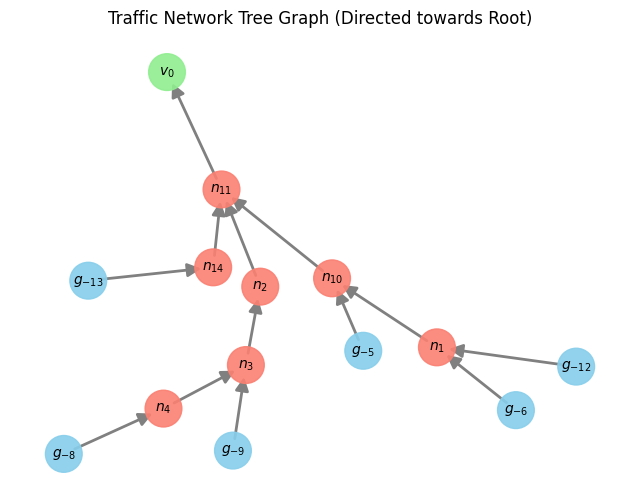

In [64]:
# edges = [(-1, 1), (-2, 1), (-3, 2), (-4, 2), (-5, 2), (2, 1), (1, 3), (3, 4), (4, 0)]
# pos = { 0: (2, 0),
#     4: (1, 0), 3: (0, 0), 1: (-1, 0), 2: (-2, 0),
#     -1: (-1, 1), -2: (-1, -1),-3: (-2, 1), -4: (-2, -1), -5: (-3, 0)}
# G = build_road_network(edges, pos=pos, verbose=1)

G = build_road_network(num_nodes=15, seed=42, verbose=1)

# Define the Policies

In [65]:
def all_open_policy(intersection):
    """Keeps all incoming queues open for the intersection."""
    intersection.current_state_incoming_queue_ids = list(intersection.incoming_queues_ids)

In [66]:
def cycle_policy(intersection):
    """Applies a simple cycling policy to determine which incoming queue is open."""
    if not intersection.incoming_queues_ids:
        intersection.current_state_incoming_queue_ids = []
        return

    # Simple cycling policy: open one incoming queue at a time
    queue_to_open_id = intersection.incoming_queues_ids[intersection.policy_step_counter % len(intersection.incoming_queues_ids)]
    intersection.current_state_incoming_queue_ids = [queue_to_open_id]

In [67]:
def greedy_longest_current_wait_policy(intersection):
    """Opens the incoming queue whose leading car has the longest current wait time."""
    if not intersection.incoming_queues_ids:
        intersection.current_state_incoming_queue_ids = []
        return

    longest_wait_time = -1
    queue_to_open_id = None

    for qid in intersection.incoming_queues_ids:
        traffic_queue = intersection.all_queues_map[qid]
        if not traffic_queue.is_empty():
            # We can't use peek_top_car_wait_time directly since it just gives wait_time,
            # but we need to compare across queues. Let's get the car object itself.
            top_car = traffic_queue.get_cars_in_queue()[0]
            if top_car.wait_time > longest_wait_time:
                longest_wait_time = top_car.wait_time
                queue_to_open_id = qid

    if queue_to_open_id is not None:
        intersection.current_state_incoming_queue_ids = [queue_to_open_id]
    else:
        intersection.current_state_incoming_queue_ids = [] # No cars in any incoming queue

In [68]:
def longest_current_wait_policy(intersection):
    """Opens the incoming queue whose leading car has the longest current wait time."""
    if not intersection.incoming_queues_ids:
        intersection.current_state_incoming_queue_ids = []
        return

    longest_wait_time = -1
    queue_to_open_id = None

    for qid in intersection.incoming_queues_ids:
        traffic_queue = intersection.all_queues_map[qid]
        if not traffic_queue.is_empty():
            # We can't use peek_top_car_wait_time directly since it just gives wait_time,
            # but we need to compare across queues. Let's get the car object itself.
            top_car_wait_time = max([car.wait_time for car in traffic_queue.get_cars_in_queue()])
            if top_car_wait_time > longest_wait_time:
                longest_wait_time = top_car_wait_time
                queue_to_open_id = qid

    if queue_to_open_id is not None:
        intersection.current_state_incoming_queue_ids = [queue_to_open_id]
    else:
        intersection.current_state_incoming_queue_ids = [] # No cars in any incoming queue

In [69]:
def longest_cumulative_wait_policy(intersection):
    """Opens the incoming queue whose leading car has the longest total travel time."""
    if not intersection.incoming_queues_ids:
        intersection.current_state_incoming_queue_ids = []
        return

    longest_total_travel_time = -1
    queue_to_open_id = None

    for qid in intersection.incoming_queues_ids:
        traffic_queue = intersection.all_queues_map[qid]
        if not traffic_queue.is_empty():
            top_car = traffic_queue.get_cars_in_queue()[0]
            if top_car.total_travel_time > longest_total_travel_time:
                longest_total_travel_time = top_car.total_travel_time
                queue_to_open_id = qid

    if queue_to_open_id is not None:
        intersection.current_state_incoming_queue_ids = [queue_to_open_id]
    else:
        intersection.current_state_incoming_queue_ids = [] # No cars in any incoming queue

# Run Simulations

In [70]:
# Define a fixed number of timesteps for consistency
num_timesteps = 2000
# Probability of a car being generated at each time step
# default_generation_rate = 0.1 # subcritical
default_generation_rate = 1 / sum(1 for node in G.nodes() if G.in_degree(node) == 0) # critical point = 1 / num_generators
# default_generation_rate = 0.3 # supercritical

policy_list = [
    all_open_policy,
    cycle_policy,
    longest_current_wait_policy,
    longest_cumulative_wait_policy
]

grouped_travel_times, intersection_costs_history, percent_cars_finished_by_policy = run_multiple_simulations(G, num_timesteps=num_timesteps, all_policies_list=policy_list, generation_rates=default_generation_rate, verbose=0)

In [71]:
dpi = 300

# Plot the Results

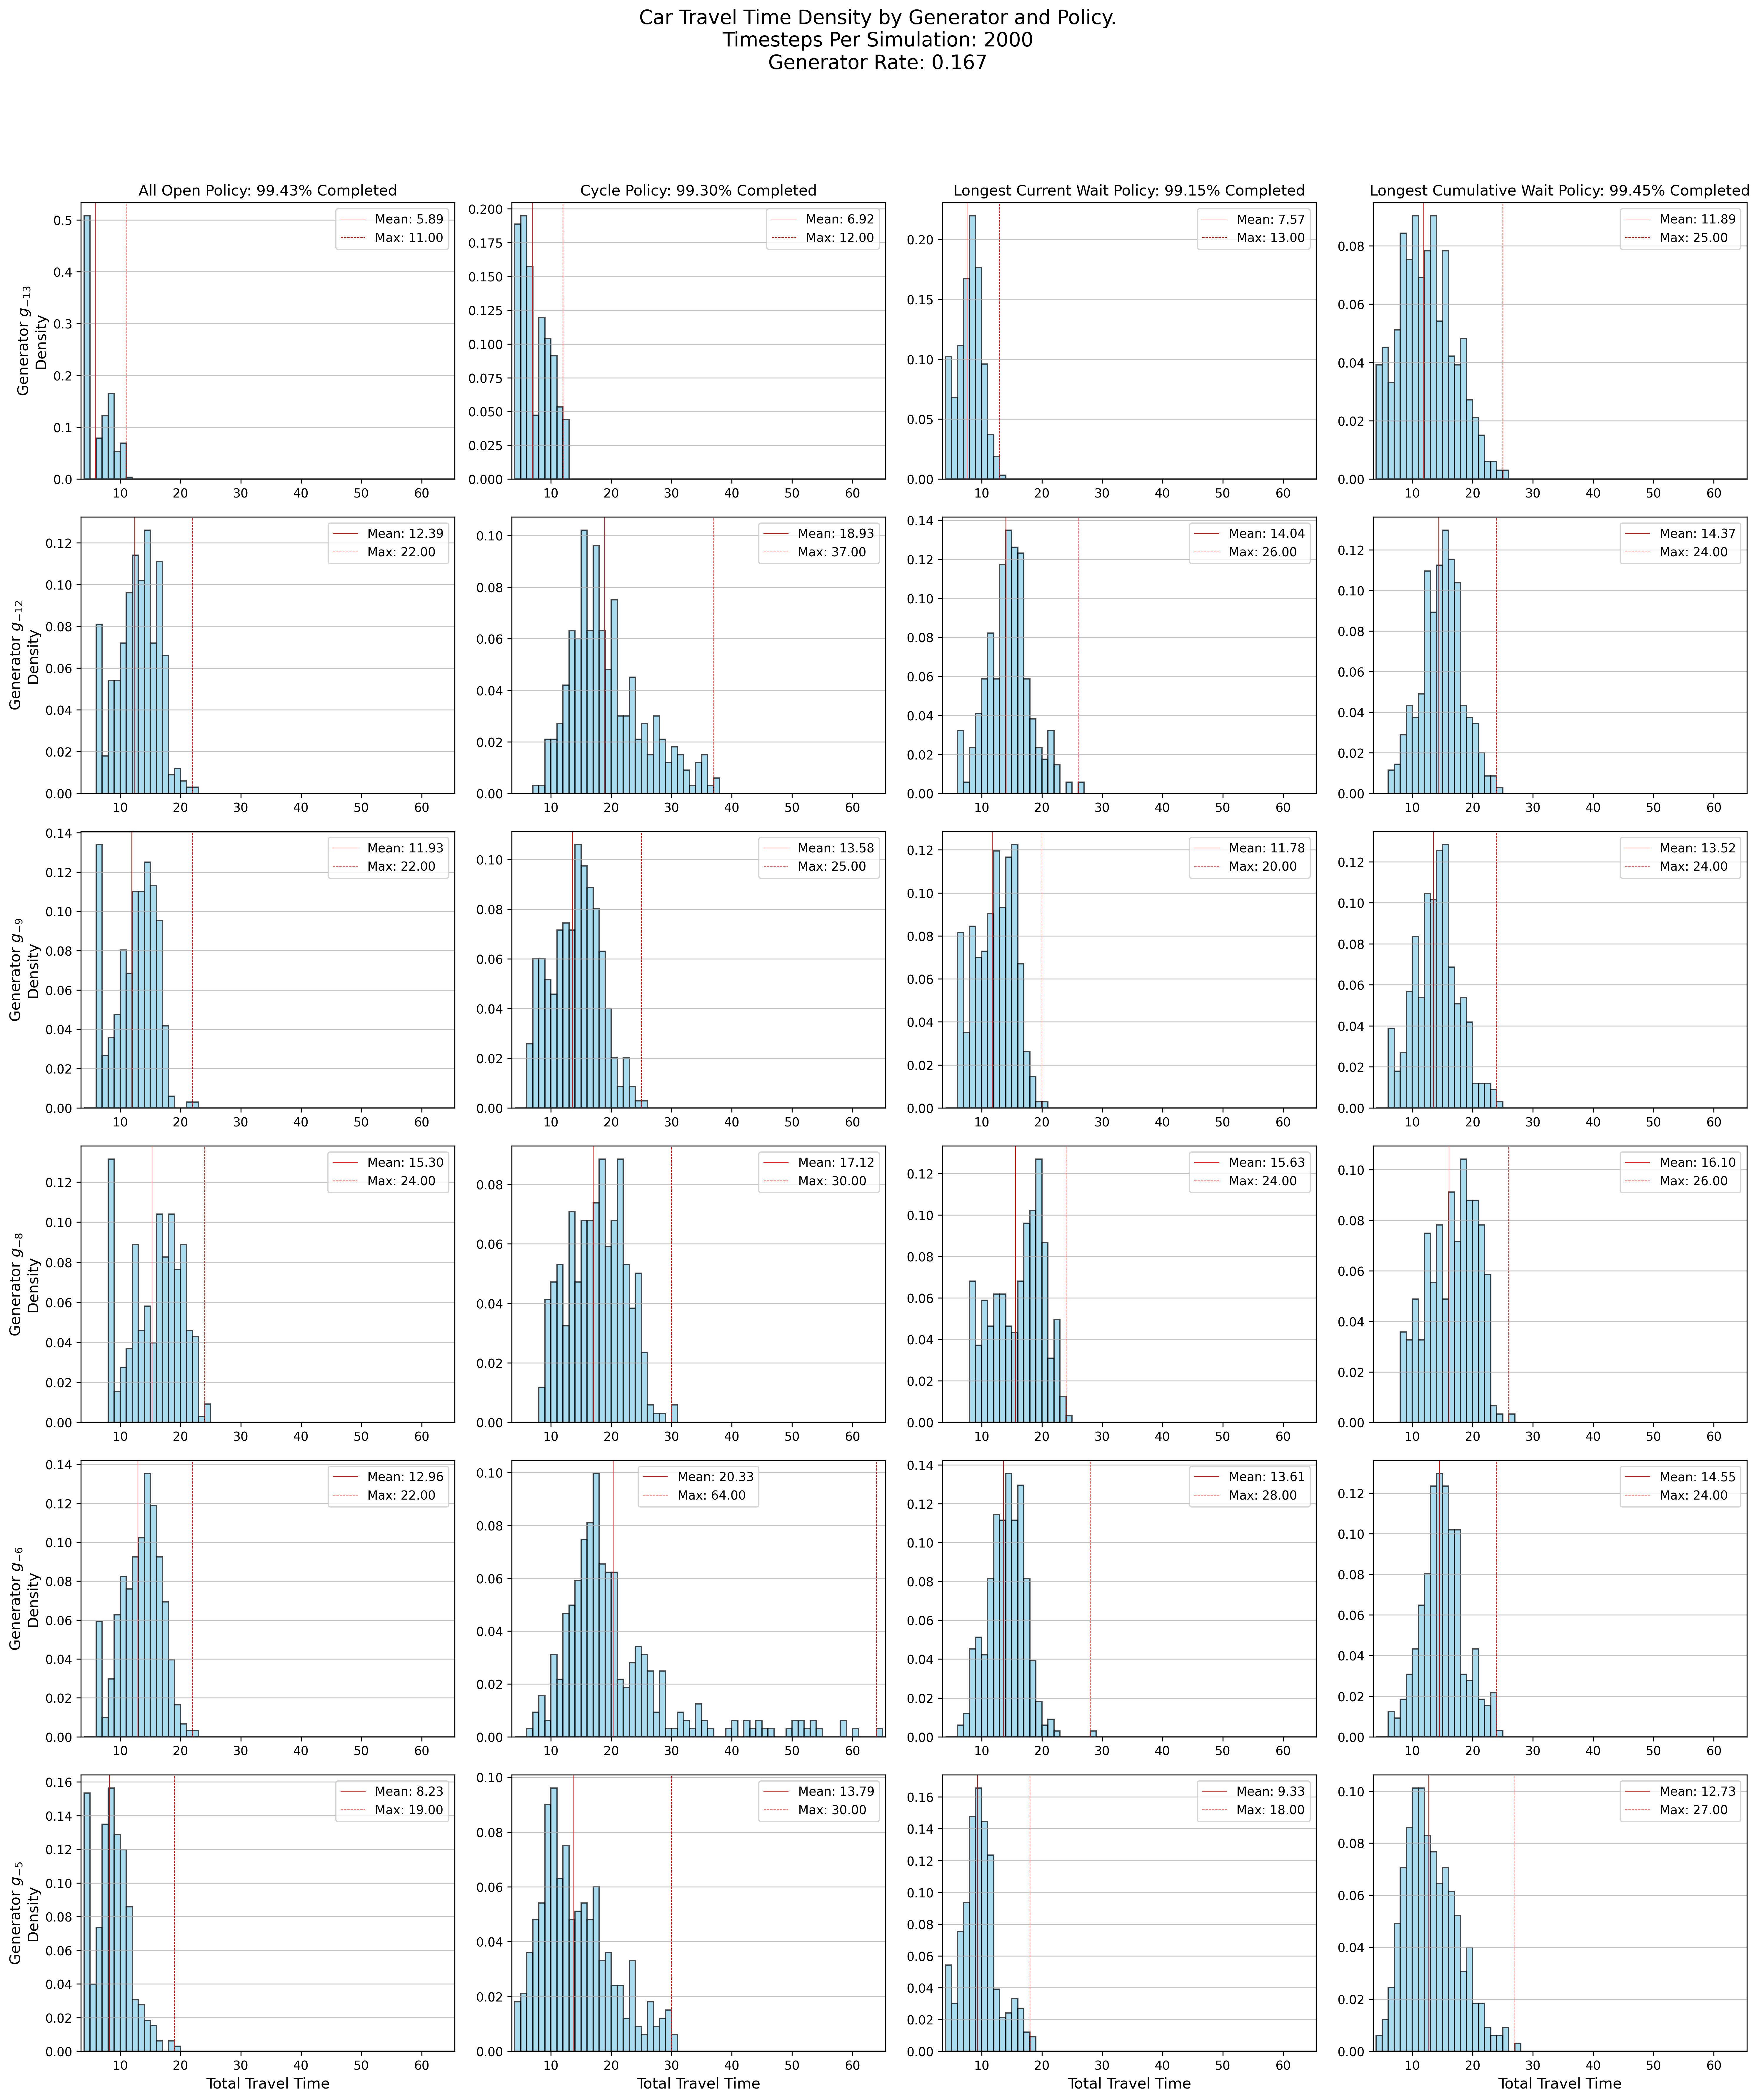

In [72]:
plot_travel_times_by_policy(grouped_travel_times, percent_cars_finished_by_policy, dpi=dpi)

<>:34: SyntaxWarning: invalid escape sequence '\l'
<>:34: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3902552891.py:34: SyntaxWarning: invalid escape sequence '\l'
  labels[node] = f"\n\n$g_{{{node}}}$\n$\lambda_{{{node}}} = {static_generation_rates.get(node, 0.0):.2f}$\n $\\tau_{{{node}}} = {generator_costs.get(node, 0):.2f}$"


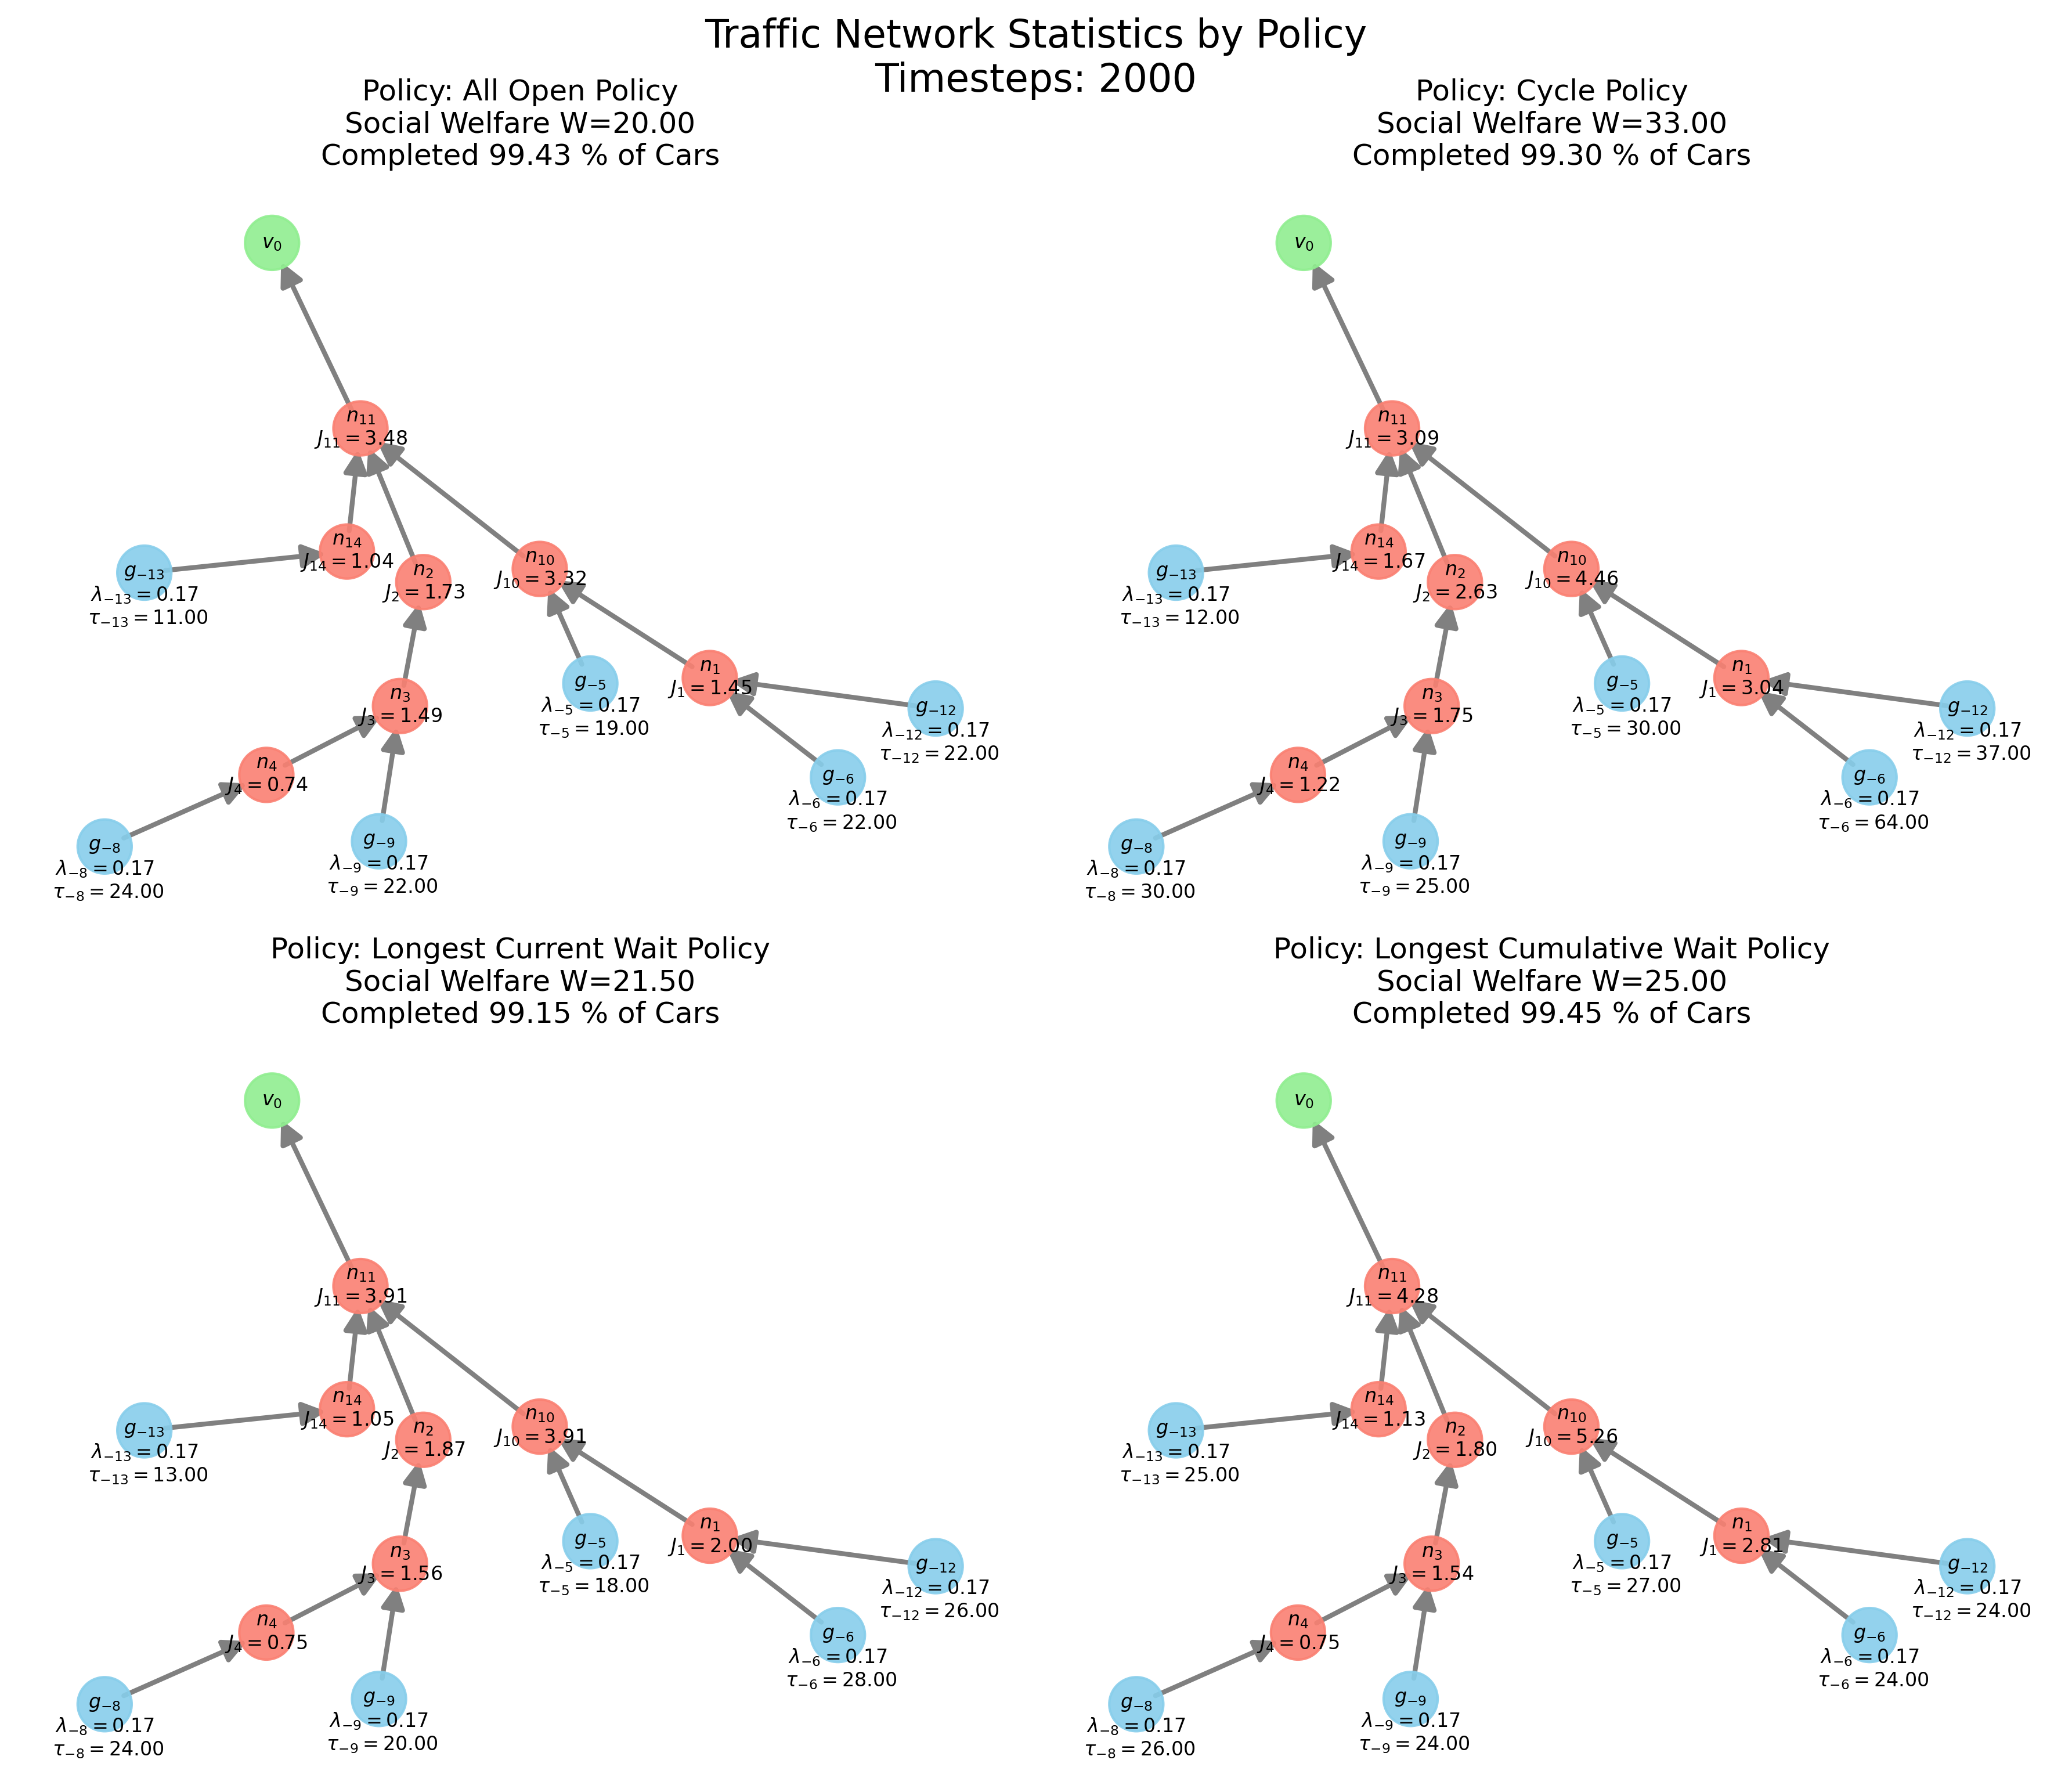

In [73]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=dpi)
axes = axes.flatten() # Flatten the 2x2 array of axes for easier iteration

# Pre-calculate position for consistent layout across all subplots
plot_pos = nx.spring_layout(G, seed=42)

# Get generator rates once as they are consistent across policies
static_generation_rates = {k: default_generation_rate for k in G.nodes() if G.in_degree(k) == 0}

for i, policy_func in enumerate(policy_list):
    policy_name = policy_func.__name__
    ax = axes[i]

    # Retrieve data for the current policy
    current_grouped_travel_times = grouped_travel_times[policy_name]
    current_intersection_costs_history = intersection_costs_history[policy_name]
    current_percent_cars_finished = percent_cars_finished_by_policy[policy_name]

    # Calculate generator and intersection costs based on max travel/wait times
    generator_costs = {}
    for gen_id, times in current_grouped_travel_times.items():
        generator_costs[gen_id] = max(times) if times else 0 # Use 0 if no cars completed

    intersection_costs = {}
    for int_id, costs_list in current_intersection_costs_history.items():
        intersection_costs[int_id] = max(costs_list) if costs_list else 0 # Use 0 if no costs recorded

    node_colors = []
    labels = {}
    for node in G.nodes():
        node_type = G.nodes[node]['type']
        if node_type == 'generator':
            node_colors.append('skyblue')
            labels[node] = f"\n\n$g_{{{node}}}$\n$\lambda_{{{node}}} = {static_generation_rates.get(node, 0.0):.2f}$\n $\\tau_{{{node}}} = {generator_costs.get(node, 0):.2f}$"
        elif node_type == 'n intersection':
            node_colors.append('salmon')
            labels[node] = f"$n_{{{node}}}$\n$J_{{{node}}} = {intersection_costs.get(node, 0):.2f}$"
        else: # Safe Region
            node_colors.append('lightgreen')
            labels[node] = f"$v_{{{node}}}$"

    nx.draw_networkx_nodes(G, plot_pos, node_color=node_colors, node_size=500, alpha=0.9, ax=ax)
    nx.draw_networkx_edges(G, plot_pos, edgelist=G.edges(), arrows=True, arrowsize=20, width=2, edge_color='gray', ax=ax)
    nx.draw_networkx_labels(G, plot_pos, labels=labels, font_size=8, font_weight='bold', ax=ax)

    social_welfare = sum(generator_cost for generator_cost in generator_costs.values()) / len(generator_costs) if generator_costs else 0
    ax.set_title(f"Policy: {policy_name.replace('_', ' ').title()}\nSocial Welfare W={social_welfare:.2f}\nCompleted {current_percent_cars_finished*100:.2f} % of Cars", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.suptitle(f"Traffic Network Statistics by Policy\nTimesteps: {num_timesteps}", y=1.02, fontsize=16)
plt.savefig(f'net_states_{default_generation_rate:.2f}.pdf', bbox_inches='tight')
plt.show()

TODO:

* Weigh generator costs by $\alpha_k$
* Policies should return a map open[out_queue] = set(in_queues), detailing open connections from in to out queues, and cars should be selected to flow randomly during that time step until no more can flow (either by out being full or in being empty). The would also entail there being an expected number of cars generated per time step at the generators, but this might have the effect of just speeding up what each time step means. Perhaps one car still is moved at each intersection per time step, but randomize over the possible out-edges? I don't need to worry for now, as it's a tree.


NOTES:

Generators closer to the safe zone prefer a distributed/greedy/longest_current_wait policy, while generators farther from safety prefer priority under longest_cumulative_wait_policy